# Chapter: Finding Groups in Process Data: Clustering & Mixture Modeling

# Topic: K-Means clustering

In [1]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          K-Means clustering of Etch data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [2]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
# fetch data
import scipy.io

matlab_data = scipy.io.loadmat('MACHINE_Data.mat', struct_as_record = False)
Etch_data = matlab_data['LAMDATA']
calibration_dataAll = Etch_data[0,0].calibration # calibration_dataAll[i,0] corresponds to a 2D data from ith batch where columns correspond to different variables 

variable_names = Etch_data[0,0].variables

In [4]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          perform Multiway PCA
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [5]:
# generate unfolded data matrix
n_vars = variable_names.size - 2 # first 2 columns are not process variables
n_samples = 85 # following the work of He et al.

unfolded_dataMatrix = np.empty((1,n_vars*n_samples))
for expt in range(calibration_dataAll.size):
    calibration_expt = calibration_dataAll[expt,0][5:90,2:] # removing first 5 measurements as done in He et al.
    
    if calibration_expt.shape[0] < 85:
        continue
    
    unfolded_row = np.ravel(calibration_expt, order='F')[np.newaxis,:]
    unfolded_dataMatrix = np.vstack((unfolded_dataMatrix, unfolded_row))

unfolded_dataMatrix = unfolded_dataMatrix[1:,:]

In [6]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_normal = scaler.fit_transform(unfolded_dataMatrix)

In [7]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3) # following the work of He et al.
score_train = pca.fit_transform(data_train_normal)

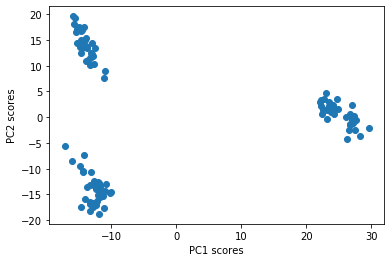

In [19]:
# visualize in 2D
plt.figure()
plt.scatter(score_train[:,0],score_train[:,1])
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

In [9]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          K-Means on PCA scores
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

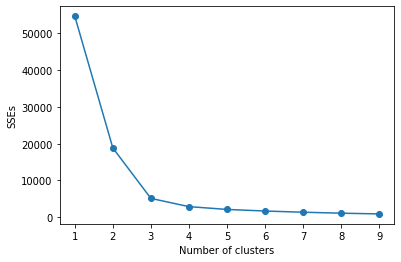

In [10]:
# determining number of clusters via elbow method
SSEs = []
for n_cluster in range(1, 10):
    kmeans = KMeans(n_clusters = n_cluster, random_state = 100).fit(score_train)
    SSEs.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1,10), SSEs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSEs')
plt.show()

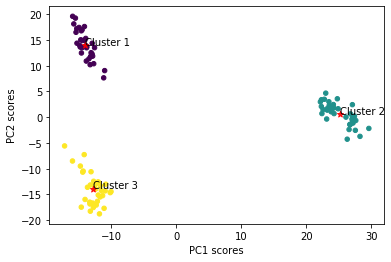

In [15]:
# fit k-means model
n_cluster = 3
kmeans = KMeans(n_clusters = n_cluster, random_state = 100).fit(score_train)
cluster_label = kmeans.predict(score_train) # can also use kmeans.labels_

plt.figure()
plt.scatter(score_train[:, 0], score_train[:, 1], c = cluster_label, s = 20, cmap = 'viridis')
plt.xlabel('PC1 scores')
plt.ylabel('PC2 scores')
plt.show()

cluster_centers = kmeans.cluster_centers_
cluster_plot_labels = ['Cluster ' + str(i+1) for i in range(n_cluster)]
for i in range(n_cluster):
    plt.scatter(cluster_centers[i,0], cluster_centers[i,1], c = 'red', s = 40, marker = '*', alpha = 0.9)
    plt.annotate(cluster_plot_labels[i], (cluster_centers[i,0], cluster_centers[i,1]))

In [12]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          Analyzing cluster quality via silhouette plots
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [16]:
#%% average silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avgValue = silhouette_score(score_train, cluster_label)
print('Average silhouette score is :', silhouette_avgValue)

Average silhouette score is : 0.7444654654948362


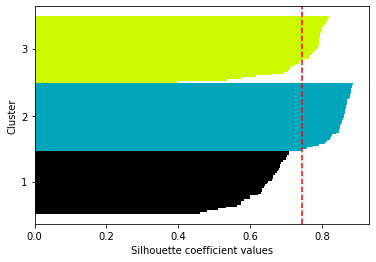

In [18]:
# silhouette plot
from matplotlib import cm

plt.figure()
silhouette_values = silhouette_samples(score_train, cluster_label)
y_lower, y_upper = 0, 0
yticks = []
for i in range(n_cluster):
    cluster_silhouette_vals = silhouette_values[cluster_label == i]
    cluster_silhouette_vals.sort()
    
    y_upper += len(cluster_silhouette_vals)
    color = cm.nipy_spectral(i / n_cluster)
    plt.barh(range(y_lower, y_upper),cluster_silhouette_vals,height=1.0,edgecolor='none',color=color)
    
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(silhouette_avgValue, color="red", linestyle="--")
plt.yticks(yticks, np.arange(n_cluster)+1)
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster')
plt.show()